# 60x60 preanalytical analysis


### Imports and environment setup

- Date of run: 2024-08-13
- Environment: python 3.12
- Packages required: pandas, numpy, sklearn, statsmodels, seaborn, matplotlib

In [1]:
# Include in the environment the code directory with the utils function
import sys
sys.path.append('../code/')

In [2]:
# Library imports
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

# Utils imports
import cohort_analysis_utils as utils

In [3]:
# Remove warnings for readability
import warnings
warnings.filterwarnings('ignore')

# Remove cell printing limits
pd.set_option('display.max_rows', None)


# Data loading and preprosessing

Let's load and harmonize the 60x60 cohort to make some comparisons with the 240 cohort.

The original excel files were saved into CSV files in the data folder of this repository, separating fields by TABs.

In [4]:
df_120 = pd.read_csv('../data/ruo_vs_mmk_20240723.csv', sep='\t', index_col=0, header=0)
df_240 = pd.read_csv('../data/ruo_240.csv', sep='\t', index_col=0, header=0)

In [5]:
# Harmonization of column names
df_120 = utils.normalize_column_names(df_120)
df_240 = utils.normalize_column_names(df_240)

In [6]:
# Ensure numeric columns are treated as such
cols_120_to_num = ['Collected_volume_mL',
                    'MMP9_RUO', 'HSPB1_RUO', 'PERM_RUO',
                    'MMP9_MMK', 'HSPB1_MMK', 'AGRIN_MMK',
                    'KPYM_MMK', 'PERM_MMK', 'Total_protein_UCFP',
                    'Total_protein_BCA']
df_120 = utils.cols_as_numbers(df_120, cols_120_to_num)

cols_240_to_num = ['Collected_volume_mL',
                    'MMP9', 'HSPB1', 'PERM', 'Total_protein_BCA']
df_240 = utils.cols_as_numbers(df_240, cols_240_to_num)

In [7]:
# Ensure categorical columns are treated as such
df_120 = utils.cols_as_category(df_120, {'Pathology':{'Benign': 0, 'Endometrial cancer': 1}})
df_240 = utils.cols_as_category(df_240, {'Pathology':{'Benign': 0, 'Endometrial cancer': 1}})

# Distribution of variables under benign and EC conditions 

## Total protein

During the discussion, we have made several plots to observe if the two datasets (60x60 vs 240) were behaving differently. Here an example: 

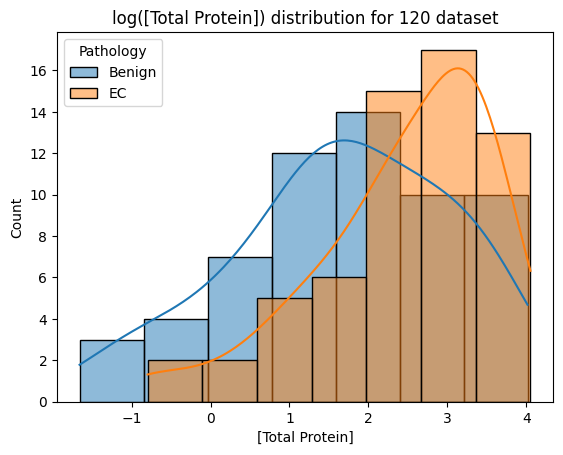

In [8]:
df_120_benign = df_120[df_120['Pathology'] == 0]
df_120_cancer = df_120[df_120['Pathology'] == 1]

df_120_benign = df_120_benign.dropna(subset=['Total_protein_BCA'])
df_120_cancer = df_120_cancer.dropna(subset=['Total_protein_BCA'])

sns.histplot(df_120_benign['Total_protein_BCA'].apply(np.log), label='Benign', kde=True)
sns.histplot(df_120_cancer['Total_protein_BCA'].apply(np.log), label='EC', kde=True)

plt.legend(title='Pathology')
plt.xlabel('[Total Protein]')
plt.ylabel('Count')
plt.title('log([Total Protein]) distribution for 120 dataset')

plt.show()

In this histogram, we observe that for the 60x60 cohort the distribution of $[TP]$ is behaving differently depending on benign and EC samples. Same was happening for all the biomarkers. In the 240 cohort that was not the case: 

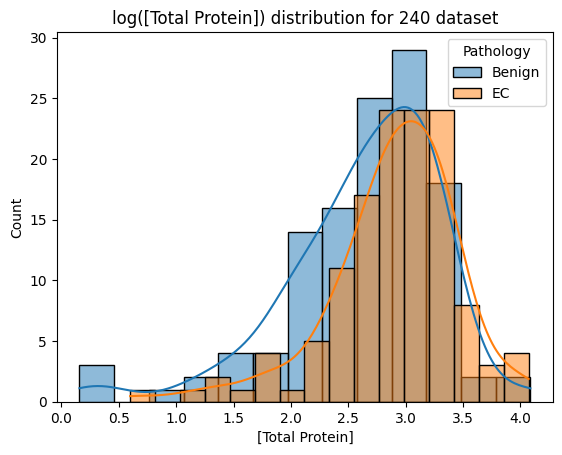

In [9]:
# Do the same for the 240 dataset
df_240_benign = df_240[df_240['Pathology'] == 0]
df_240_cancer = df_240[df_240['Pathology'] == 1]

df_240_benign = df_240_benign.dropna(subset=['Total_protein_BCA'])
df_240_cancer = df_240_cancer.dropna(subset=['Total_protein_BCA'])

sns.histplot(df_240_benign['Total_protein_BCA'].apply(np.log), label='Benign', kde=True)
sns.histplot(df_240_cancer['Total_protein_BCA'].apply(np.log), label='EC', kde=True)

plt.legend(title='Pathology')
plt.xlabel('[Total Protein]')
plt.ylabel('Count')
plt.title('log([Total Protein]) distribution for 240 dataset')

plt.show()

I’m putting these plots here, but I’m not making a comprehensive set of plots in the results folder because all those plots and the differences they express are, at the end of the day, the result of introduction of the correlation with volume of the concentration of biomarkers and the concentration of total protein. Undoing the dilution with the coefficient we have shown in the 'undo dilution’ section, we observe no significative differences between the datasets (maybe a point in favor of undoing the dilution?). 

In [10]:
# undo the dilutions
df_120_benign["final_volume"] = df_120_benign["Collected_volume_mL"] + 0.5
df_120_cancer["final_volume"] = df_120_cancer["Collected_volume_mL"] + 0.5
df_120_benign["final_total_protein"] = df_120_benign["Total_protein_BCA"].multiply(df_120_benign["final_volume"], axis=0).div(df_120_benign["Collected_volume_mL"], axis=0)
df_120_cancer["final_total_protein"] = df_120_cancer["Total_protein_BCA"].multiply(df_120_cancer["final_volume"], axis=0).div(df_120_cancer["Collected_volume_mL"], axis=0)


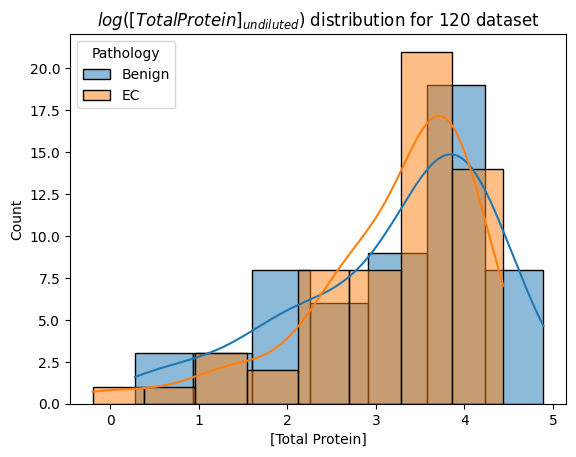

In [11]:
sns.histplot(df_120_benign['final_total_protein'].apply(np.log), label='Benign', kde=True)
sns.histplot(df_120_cancer['final_total_protein'].apply(np.log), label='EC', kde=True)

plt.legend(title='Pathology')
plt.xlabel('[Total Protein]')
plt.ylabel('Count')
plt.title('$log([Total Protein]_{undiluted})$ distribution for 120 dataset')

plt.show()

Same was happening for all the sets of variables we have tried, adding tens of plots of this analysis in the results folder could be misleading and we're avoiding it. 

## Biomarkers

# Normalization efects on the biomarkers distributions

In the following analysis, we will try to observe what happens when normalizing by $[TP]$, undoing the dilution, or both things.

In [12]:
df_120['Final_volume'] = df_120['Collected_volume_mL'] + 0.5

In [13]:
# For each biomarker, undo the dilution
df_120_undiluted = df_120.copy()
df_120_undiluted['MMP9_RUO'] = df_120_undiluted['MMP9_RUO'].multiply(df_120_undiluted['Collected_volume_mL'].div(df_120_undiluted['Final_volume'], axis=0), axis=0)
df_120_undiluted['HSPB1_RUO'] = df_120_undiluted['HSPB1_RUO'].multiply(df_120_undiluted['Collected_volume_mL'].div(df_120_undiluted['Final_volume'], axis=0), axis=0)
df_120_undiluted['PERM_RUO'] = df_120_undiluted['PERM_RUO'].multiply(df_120_undiluted['Collected_volume_mL'].div(df_120_undiluted['Final_volume'], axis=0), axis=0)
df_120_undiluted['MMP9_MMK'] = df_120_undiluted['MMP9_MMK'].multiply(df_120_undiluted['Collected_volume_mL'].div(df_120_undiluted['Final_volume'], axis=0), axis=0)
df_120_undiluted['HSPB1_MMK'] = df_120_undiluted['HSPB1_MMK'].multiply(df_120_undiluted['Collected_volume_mL'].div(df_120_undiluted['Final_volume'], axis=0), axis=0)
df_120_undiluted['AGRIN_MMK'] = df_120_undiluted['AGRIN_MMK'].multiply(df_120_undiluted['Collected_volume_mL'].div(df_120_undiluted['Final_volume'], axis=0), axis=0)
df_120_undiluted['KPYM_MMK'] = df_120_undiluted['KPYM_MMK'].multiply(df_120_undiluted['Collected_volume_mL'].div(df_120_undiluted['Final_volume'], axis=0), axis=0)
df_120_undiluted['PERM_MMK'] = df_120_undiluted['PERM_MMK'].multiply(df_120_undiluted['Collected_volume_mL'].div(df_120_undiluted['Final_volume'], axis=0), axis=0)


In [14]:
# For each biomarker, normalize the values by the total protein
df_120_normalized = df_120.copy()
df_120_normalized['MMP9_RUO'] = df_120_normalized['MMP9_RUO'].divide(df_120_normalized['Total_protein_BCA'], axis=0)
df_120_normalized['HSPB1_RUO'] = df_120_normalized['HSPB1_RUO'].divide(df_120_normalized['Total_protein_BCA'], axis=0)
df_120_normalized['PERM_RUO'] = df_120_normalized['PERM_RUO'].divide(df_120_normalized['Total_protein_BCA'], axis=0)
df_120_normalized['MMP9_MMK'] = df_120_normalized['MMP9_MMK'].divide(df_120_normalized['Total_protein_BCA'], axis=0)
df_120_normalized['HSPB1_MMK'] = df_120_normalized['HSPB1_MMK'].divide(df_120_normalized['Total_protein_BCA'], axis=0)
df_120_normalized['AGRIN_MMK'] = df_120_normalized['AGRIN_MMK'].divide(df_120_normalized['Total_protein_BCA'], axis=0)
df_120_normalized['KPYM_MMK'] = df_120_normalized['KPYM_MMK'].divide(df_120_normalized['Total_protein_BCA'], axis=0)
df_120_normalized['PERM_MMK'] = df_120_normalized['PERM_MMK'].divide(df_120_normalized['Total_protein_BCA'], axis=0)


In [15]:
# undilute biomarkes and total protein, then normalize by total protein
df_120_undiluted_and_normalized = df_120_undiluted.copy()
df_120_undiluted_and_normalized['MMP9_RUO'] = df_120_undiluted_and_normalized['MMP9_RUO'].multiply(df_120_undiluted_and_normalized['Collected_volume_mL'].div(df_120_undiluted_and_normalized['Final_volume'], axis=0), axis=0)
df_120_undiluted_and_normalized['HSPB1_RUO'] = df_120_undiluted_and_normalized['HSPB1_RUO'].multiply(df_120_undiluted_and_normalized['Collected_volume_mL'].div(df_120_undiluted_and_normalized['Final_volume'], axis=0), axis=0)
df_120_undiluted_and_normalized['PERM_RUO'] = df_120_undiluted_and_normalized['PERM_RUO'].multiply(df_120_undiluted_and_normalized['Collected_volume_mL'].div(df_120_undiluted_and_normalized['Final_volume'], axis=0), axis=0)
df_120_undiluted_and_normalized['MMP9_MMK'] = df_120_undiluted_and_normalized['MMP9_MMK'].multiply(df_120_undiluted_and_normalized['Collected_volume_mL'].div(df_120_undiluted_and_normalized['Final_volume'], axis=0), axis=0)
df_120_undiluted_and_normalized['HSPB1_MMK'] = df_120_undiluted_and_normalized['HSPB1_MMK'].multiply(df_120_undiluted_and_normalized['Collected_volume_mL'].div(df_120_undiluted_and_normalized['Final_volume'], axis=0), axis=0)
df_120_undiluted_and_normalized['AGRIN_MMK'] = df_120_undiluted_and_normalized['AGRIN_MMK'].multiply(df_120_undiluted_and_normalized['Collected_volume_mL'].div(df_120_undiluted_and_normalized['Final_volume'], axis=0), axis=0)
df_120_undiluted_and_normalized['KPYM_MMK'] = df_120_undiluted_and_normalized['KPYM_MMK'].multiply(df_120_undiluted_and_normalized['Collected_volume_mL'].div(df_120_undiluted_and_normalized['Final_volume'], axis=0), axis=0)
df_120_undiluted_and_normalized['PERM_MMK'] = df_120_undiluted_and_normalized['PERM_MMK'].multiply(df_120_undiluted_and_normalized['Collected_volume_mL'].div(df_120_undiluted_and_normalized['Final_volume'], axis=0), axis=0)
df_120_undiluted_and_normalized['Total_protein_BCA'] = df_120_undiluted_and_normalized['Total_protein_BCA'].multiply(df_120_undiluted_and_normalized['Collected_volume_mL'].div(df_120_undiluted_and_normalized['Final_volume'], axis=0), axis=0)

df_120_undiluted_and_normalized['MMP9_RUO'] = df_120_undiluted_and_normalized['MMP9_RUO'].divide(df_120_undiluted_and_normalized['Total_protein_BCA'], axis=0)
df_120_undiluted_and_normalized['HSPB1_RUO'] = df_120_undiluted_and_normalized['HSPB1_RUO'].divide(df_120_undiluted_and_normalized['Total_protein_BCA'], axis=0)
df_120_undiluted_and_normalized['PERM_RUO'] = df_120_undiluted_and_normalized['PERM_RUO'].divide(df_120_undiluted_and_normalized['Total_protein_BCA'], axis=0)
df_120_undiluted_and_normalized['MMP9_MMK'] = df_120_undiluted_and_normalized['MMP9_MMK'].divide(df_120_undiluted_and_normalized['Total_protein_BCA'], axis=0)
df_120_undiluted_and_normalized['HSPB1_MMK'] = df_120_undiluted_and_normalized['HSPB1_MMK'].divide(df_120_undiluted_and_normalized['Total_protein_BCA'], axis=0)
df_120_undiluted_and_normalized['AGRIN_MMK'] = df_120_undiluted_and_normalized['AGRIN_MMK'].divide(df_120_undiluted_and_normalized['Total_protein_BCA'], axis=0)
df_120_undiluted_and_normalized['KPYM_MMK'] = df_120_undiluted_and_normalized['KPYM_MMK'].divide(df_120_undiluted_and_normalized['Total_protein_BCA'], axis=0)
df_120_undiluted_and_normalized['PERM_MMK'] = df_120_undiluted_and_normalized['PERM_MMK'].divide(df_120_undiluted_and_normalized['Total_protein_BCA'], axis=0)


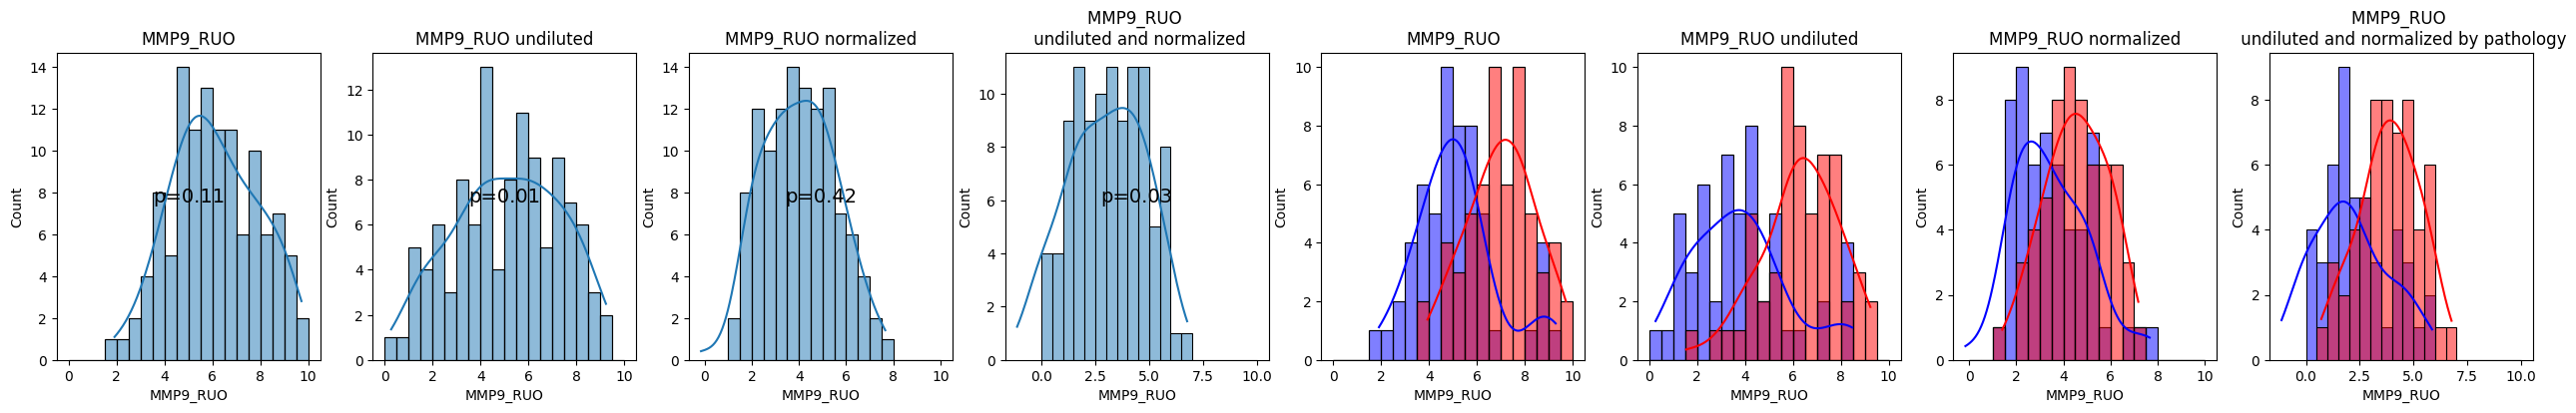

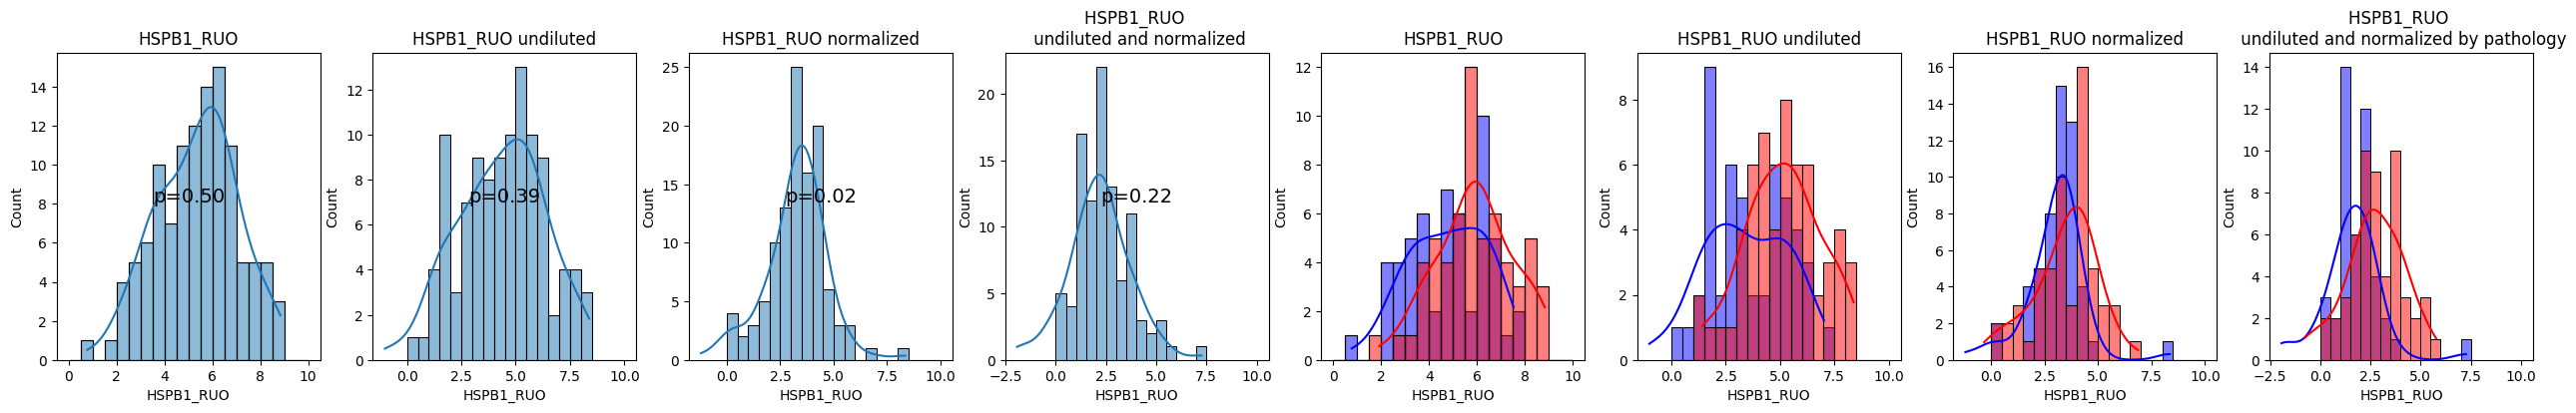

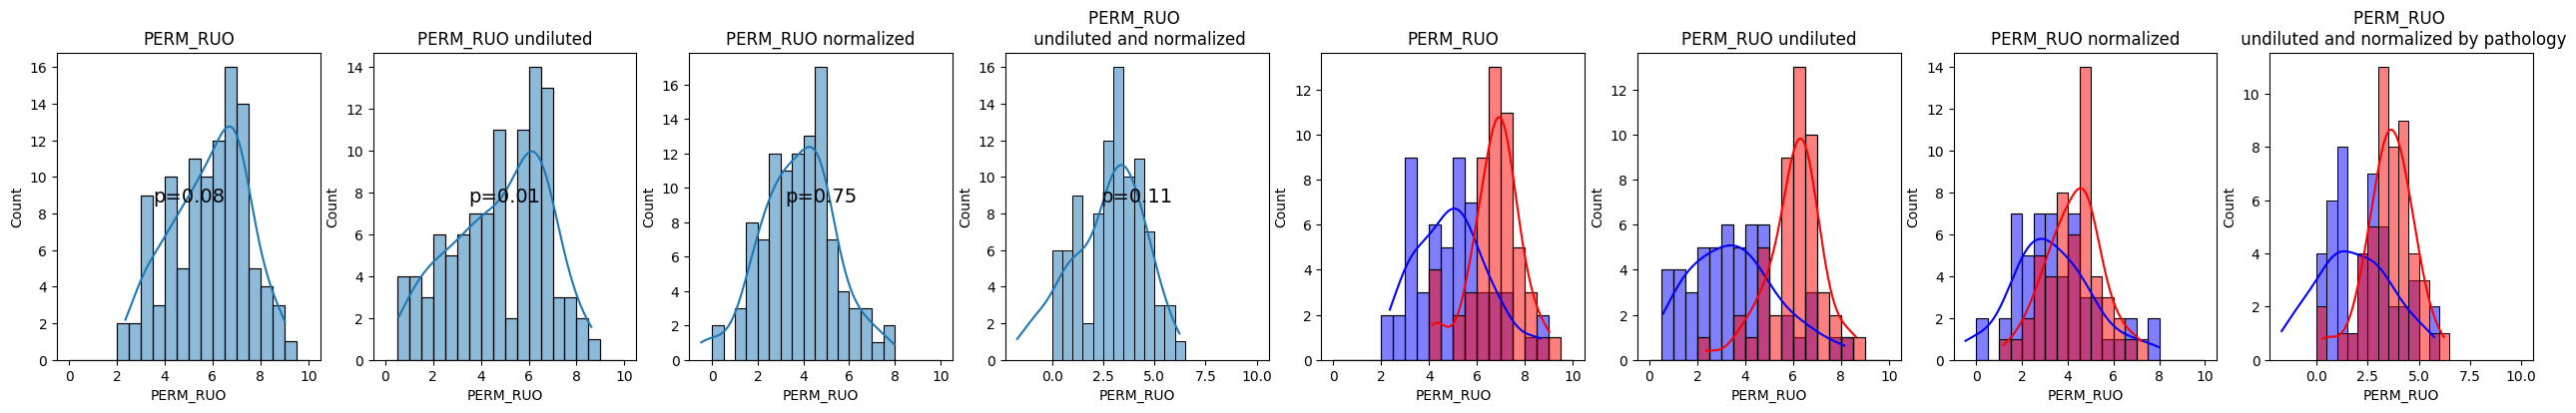

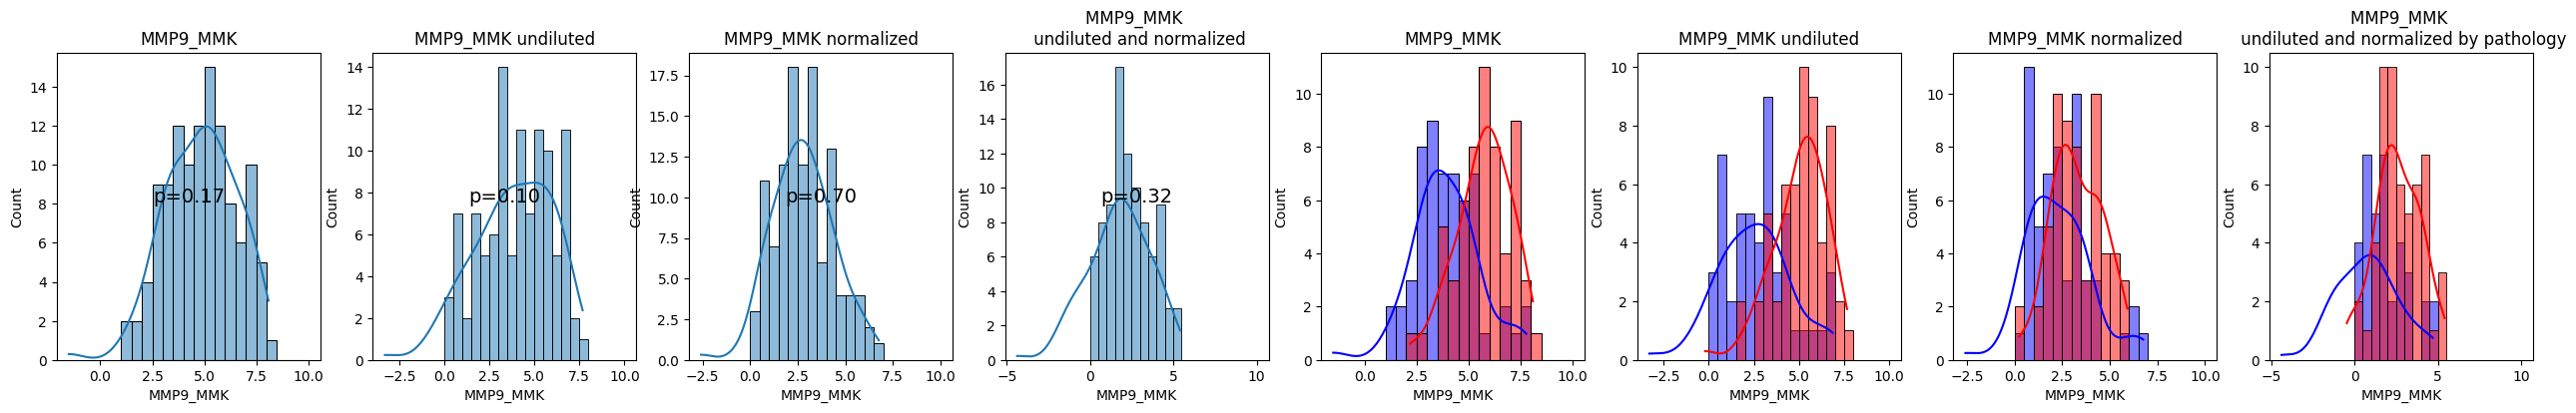

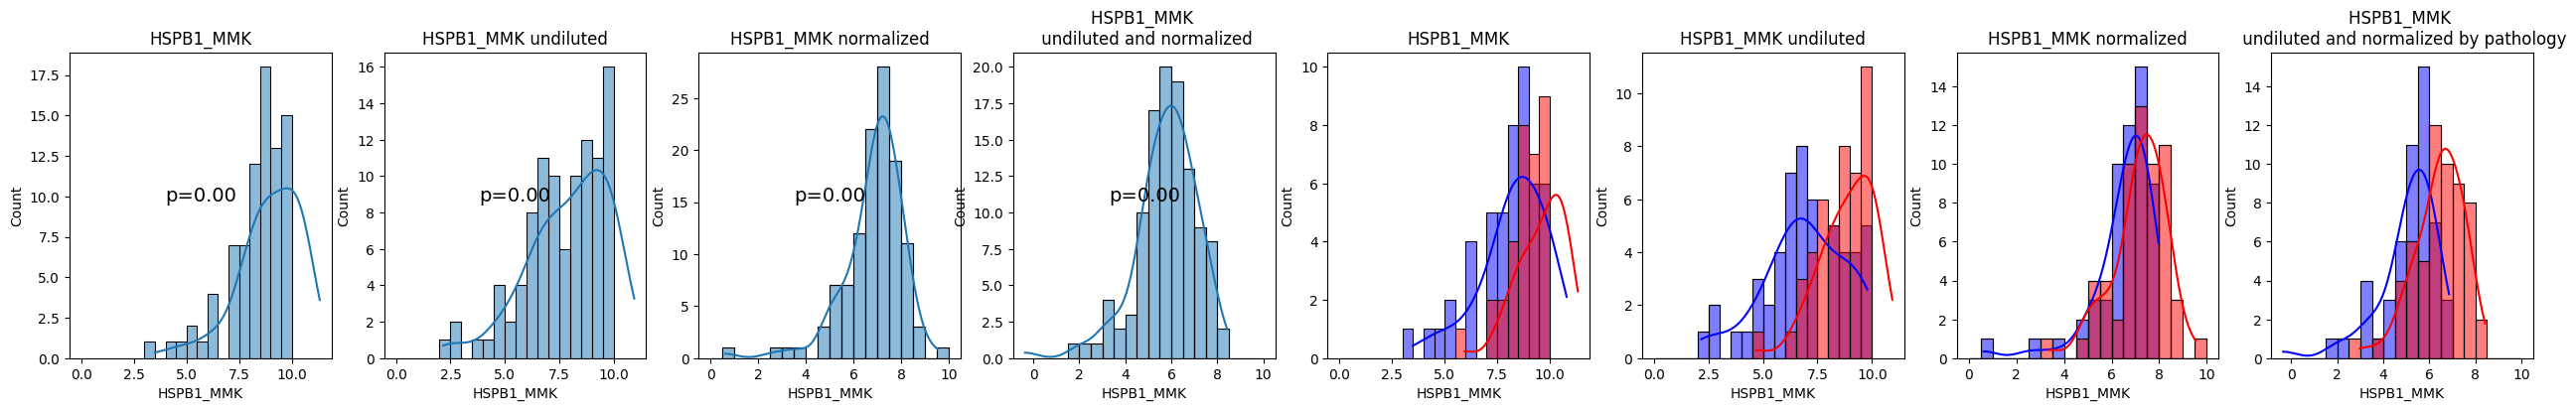

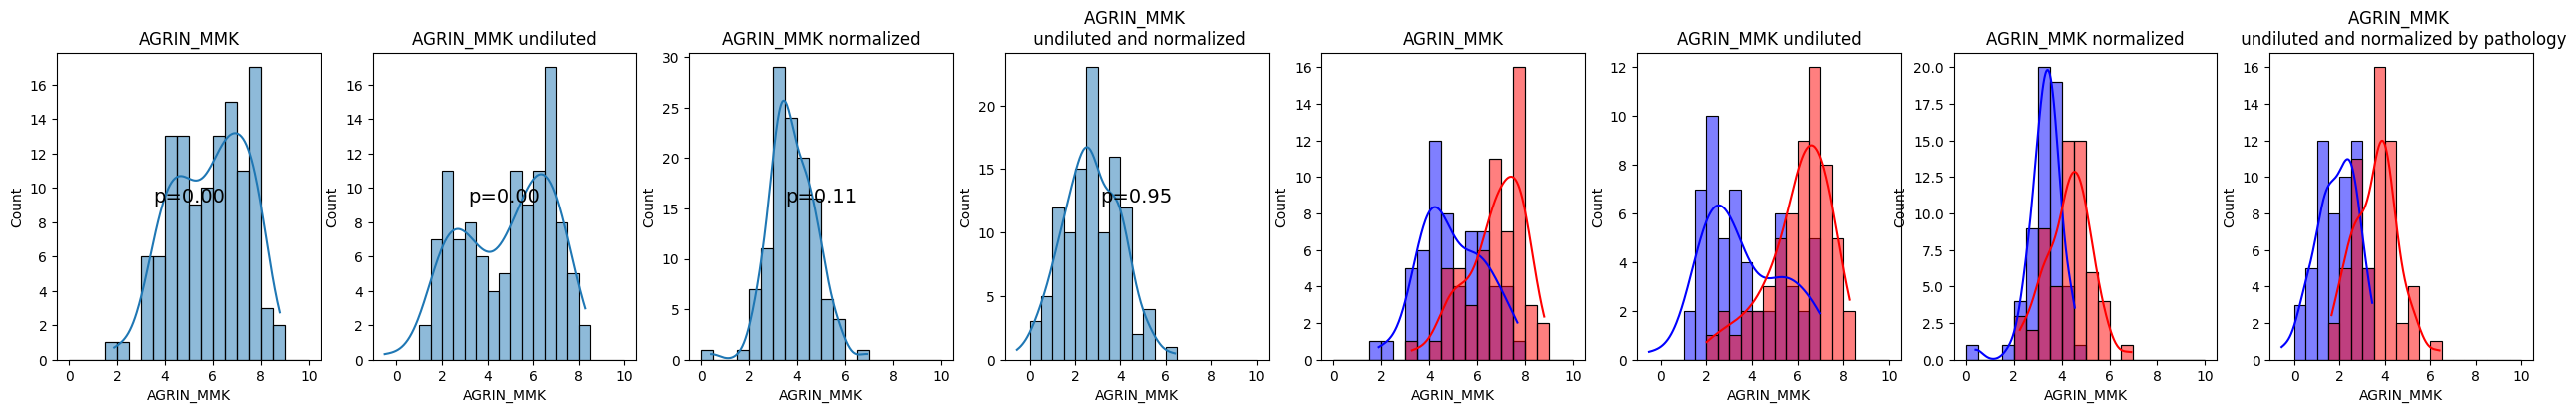

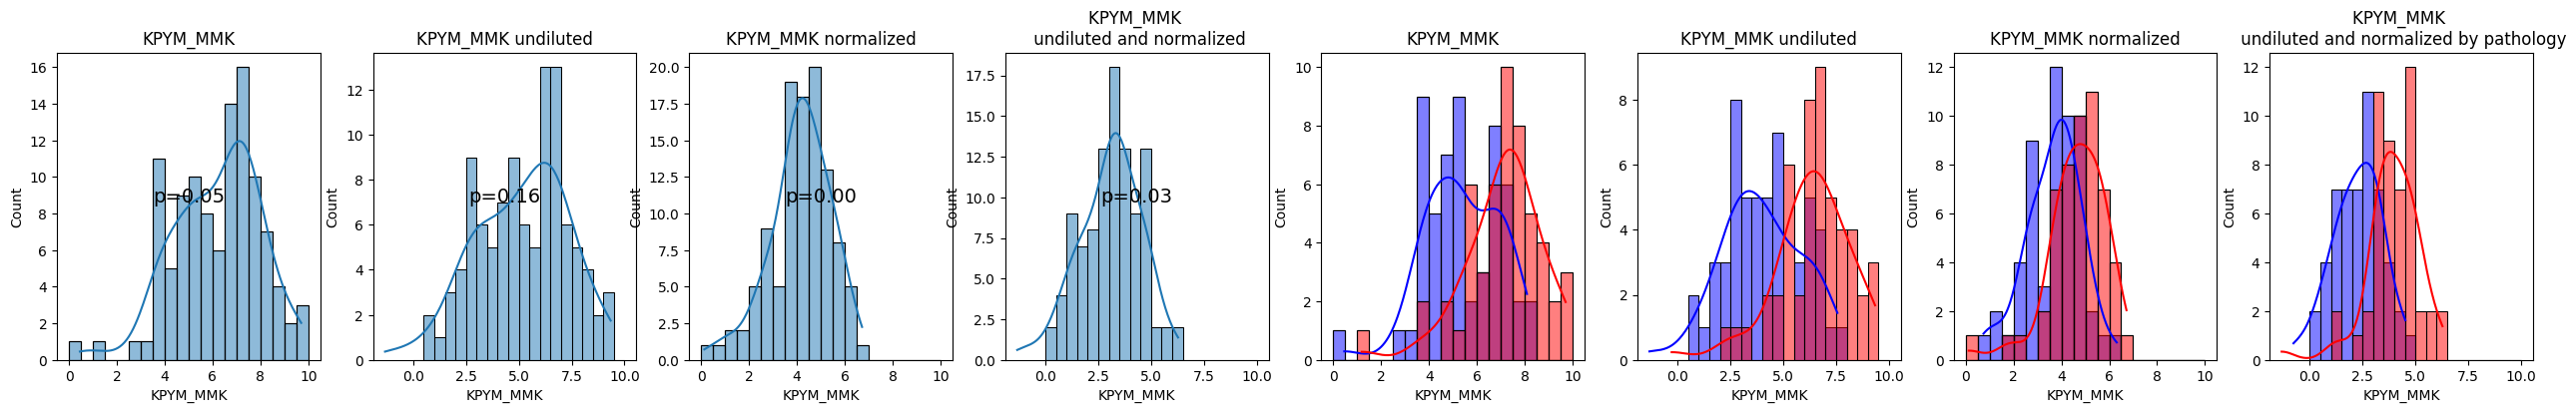

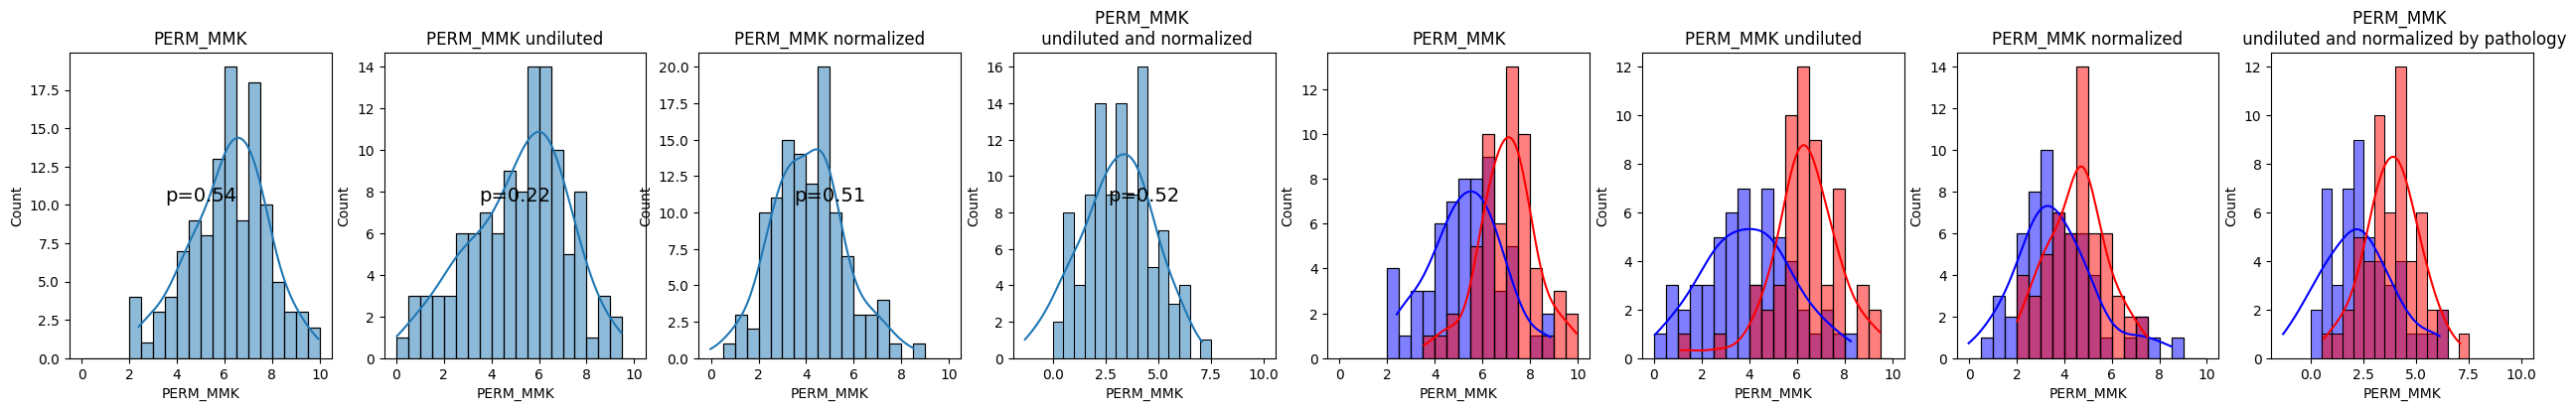

In [16]:
BIOMARKERS_120 = ['MMP9_RUO', 'HSPB1_RUO', 'PERM_RUO', 'MMP9_MMK', 'HSPB1_MMK', 'AGRIN_MMK', 'KPYM_MMK', 'PERM_MMK']

bins = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10]

for biomarker in BIOMARKERS_120:
    fig, axs = plt.subplots(1, 8, figsize=(32, 4))
    sns.histplot(df_120[biomarker].apply(np.log), ax=axs[0], kde=True, bins=bins)
    axs[0].set_title(biomarker)
    stat, p = stats.normaltest(df_120[biomarker].apply(np.log).replace([np.inf, -np.inf]).dropna())
    axs[0].text(0.5, 0.5, f"p={p:.2f}", horizontalalignment='center', verticalalignment='bottom', transform=axs[0].transAxes, fontsize=14)
    
    sns.histplot(df_120_undiluted[biomarker].apply(np.log), ax=axs[1], kde=True, bins=bins)
    stat, p = stats.normaltest(df_120_undiluted[biomarker].apply(np.log).replace([np.inf, -np.inf]).dropna())
    axs[1].text(0.5, 0.5, f"p={p:.2f}", horizontalalignment='center', verticalalignment='bottom', transform=axs[1].transAxes, fontsize=14)
    axs[1].set_title(biomarker + ' undiluted')
    
    sns.histplot(df_120_normalized[biomarker].apply(np.log), ax=axs[2], kde=True, bins=bins)
    stat, p = stats.normaltest(df_120_normalized[biomarker].apply(np.log).replace([np.inf, -np.inf]).dropna())
    axs[2].text(0.5, 0.5, f"p={p:.2f}", horizontalalignment='center', verticalalignment='bottom', transform=axs[2].transAxes, fontsize=14)
    axs[2].set_title(biomarker + ' normalized')

    sns.histplot(df_120_undiluted_and_normalized[biomarker].apply(np.log), ax=axs[3], kde=True, label='Benign', bins=bins)
    stat, p = stats.normaltest(df_120_undiluted_and_normalized[biomarker].apply(np.log).replace([np.inf, -np.inf]).dropna())
    axs[3].text(0.5, 0.5, f"p={p:.2f}", horizontalalignment='center', verticalalignment='bottom', transform=axs[3].transAxes, fontsize=14)
    axs[3].set_title(biomarker + ' \n undiluted and normalized')

    sns.histplot(df_120[df_120['Pathology']==0][biomarker].apply(np.log), ax=axs[4], kde=True, color='blue', label='Benign', bins=bins)
    sns.histplot(df_120[df_120['Pathology']==1][biomarker].apply(np.log), ax=axs[4], kde=True, color='red', label='Cancer', bins=bins)
    axs[4].set_title(biomarker)
    
    sns.histplot(df_120_undiluted[df_120_undiluted['Pathology']==0][biomarker].apply(np.log), ax=axs[5], kde=True, color='blue', label='Benign', bins=bins)
    sns.histplot(df_120_undiluted[df_120_undiluted['Pathology']==1][biomarker].apply(np.log), ax=axs[5], kde=True, color='red', label='Cancer', bins=bins)
    axs[5].set_title(biomarker + ' undiluted')
    
    sns.histplot(df_120_normalized[df_120_normalized['Pathology']==0][biomarker].apply(np.log), ax=axs[6], kde=True, color='blue', label='Benign', bins=bins)
    sns.histplot(df_120_normalized[df_120_normalized['Pathology']==1][biomarker].apply(np.log), ax=axs[6], kde=True, color='red', label='Cancer', bins=bins)
    axs[6].set_title(biomarker + ' normalized')
    
    sns.histplot(df_120_undiluted_and_normalized[df_120_undiluted_and_normalized['Pathology']==0][biomarker].apply(np.log), ax=axs[7], kde=True, color='blue', label='Benign', bins=bins)
    sns.histplot(df_120_undiluted_and_normalized[df_120_undiluted_and_normalized['Pathology']==1][biomarker].apply(np.log), ax=axs[7], kde=True, color='red', label='Cancer', bins=bins)
    axs[7].set_title(biomarker + ' \n undiluted and normalized by pathology')
    
    plt.show()

Here we can observe, for each biomarker the shape of their distribution and the $p$-value returned by the normality test for the original readout and for each of the methods applied. We are also plotting ─for illustrative purposes─ the distributions separating the data by EC condition.

#### Some observations:

- Undoing the dilution has a different effect than normalizing by total protein.  
- Normalizing tends to “normalize” (make a thinner bell) to the biomarker's readout. This ‘bell shape’ is better suited for parametric methods such as logistic regression. But, when testing for normality, we don't observe a consistency on this feature (nor for undiluting neither for undiluting and normalizing).
- Normalizing makes the EC distributions overlap more, undoing the dilution separates the distributions.  
- Normalizing by total protein as means of undoing the dilution doesn’t have the same effect on the data as undoing the dilution. 